In [1]:
# Imports we will use
import torch
import gc
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Function
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
from pathlib import Path
from sklearn.metrics import r2_score
from astropy.visualization import make_lupton_rgb
from sklearn.manifold import Isomap
from train_utils import *
import time
import os
import json

%matplotlib inline
plt.rcParams.update({'font.size': 12})

# Find if cuda is available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [2]:
#fix seed
seed = 13
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

## Load Data

In [3]:
# Specify paths, load in data, and subsample labels
head = Path.cwd().parents[1]
source_img_path = head / 'data/mb_paper_source_final/mb_paper_source_final.npy'
target_img_path = head / 'data/mb_paper_target_final/mb_paper_target_final.npy'
source_meta = head / 'data/mb_paper_source_final/mb_paper_source_final_metadata.csv'
target_meta = head / 'data/mb_paper_target_final/mb_paper_target_final_metadata.csv'
batch_size = 128
source_train_dataloader, source_test_dataloader, source_val_dataloader, source_data = create_dataloader(source_img_path, source_meta, batch_size)
target_train_dataloader, target_test_dataloader, target_val_dataloader, target_data = create_dataloader(target_img_path, target_meta, batch_size)
isomap_source_label_sample = pd.read_csv(source_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]
isomap_target_label_sample = pd.read_csv(target_meta)['PLANE_1-OBJECT_1-MASS_PROFILE_1-theta_E-g'].tolist()[:1000]

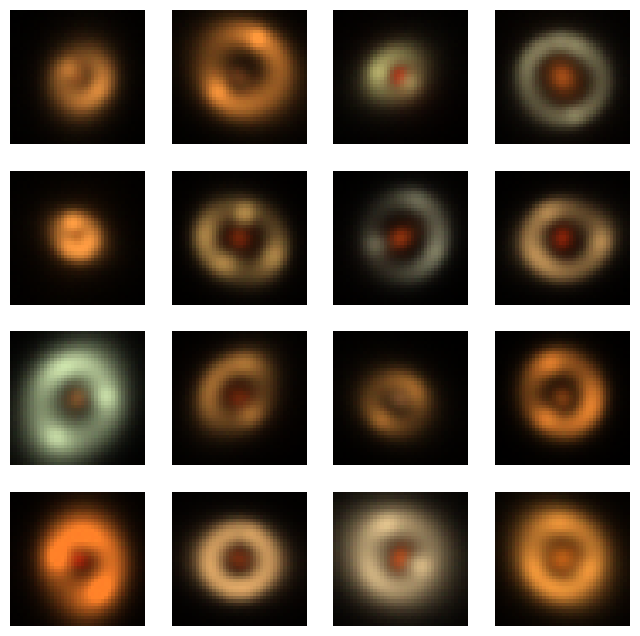

In [4]:
# Visualize source data
visualize_data(source_data)

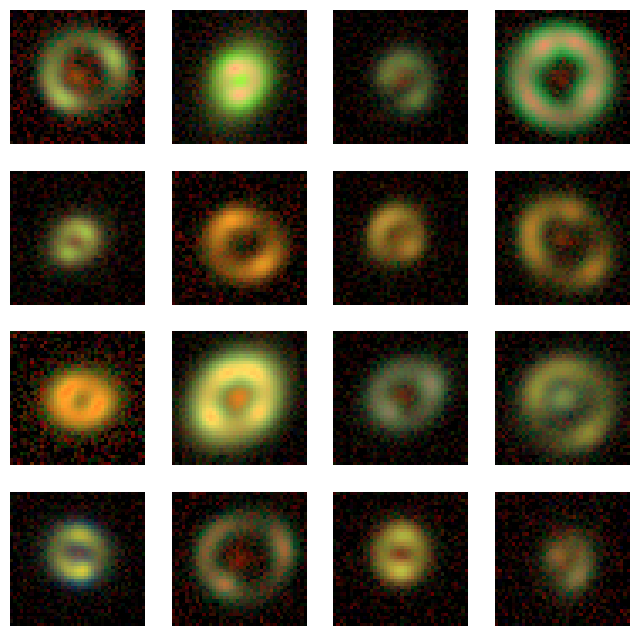

In [5]:
# Visualize target data
visualize_data(target_data)

## Model Setup

In [6]:
# Choose how you prefer to evolve beta and the DA Weight
def da_weight_function(epoch):
    """ Linear evolving DA weighting in loss function. """
    if epoch < evolv_epoch:
        da_weight = init_wt_da - ((init_wt_da - final_wt_da) * (epoch / n_epoch))
    else:
        da_weight = final_wt_da
    return 0.0

def beta_function(epoch):
    """ Linear evolving beta weighting in loss function until halfway through total epochs. """
    if epoch < evolv_epoch:
        beta_val = beta_init - (beta_init - beta_final) * (epoch / evolv_epoch)
    else:
        beta_val = beta_final
    return beta_val

# Initialize hyperparameters
learning_rate = 1e-5
n_epoch = 300

evolv_epoch = 250
init_wt_da = 0.0
final_wt_da = 0.0
beta_init = 1.0
beta_final = 0.0

In [7]:
from torch.optim.lr_scheduler import MultiStepLR
# Initialize model
model = NeuralNetworkMVE(npix=40).cuda()

# Loss Functions / Optimizers
regressor_loss_fn = nn.MSELoss().cuda()
da_loss_fn = MMD_loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[100, 200, 250, 275], gamma=0.5)

In [8]:
# To continue training from a past model, enter path into load_mod_name
# Else, enter None, and you still have to run the function.
# Then, enter save_mod_name to save for the current run  

load_mod_name = None #"models/papermve_v1_aug20_1940_A" # "models/start_code_test_2"
stats, model, optimizer, best_target_R2, best_mve_loss = initialize_state(load_mod_name, model, optimizer)


#save_mod_name = load_mod_name # may overwrite loaded model
save_mod_name = "models/papermve_noda_v3_aug22_2300_C"

## Train

Beginning Training...
Generating Isomap...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


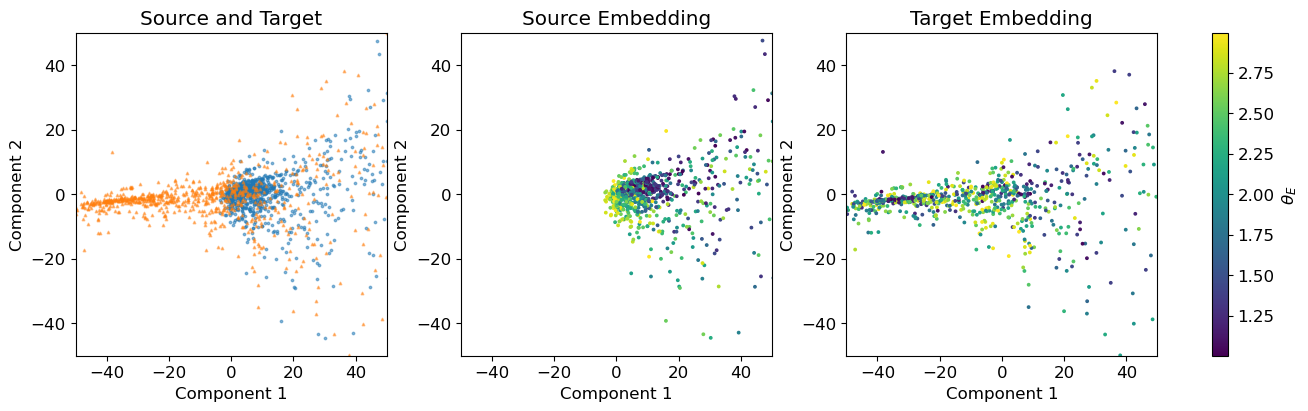


Epoch 0: 38.80s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5209
	Train Regression Loss: : 3.2914
	Train Mve Loss: : 1.5223
	Train R2 Score: : -9.0101
 Validation Statistics:
	Val Source Regression Loss: : 2.5675
	Val Target Regression Loss: : 2.4032
	Val Source R2 Score: : -6.8820
	Val Target R2 Score: : -6.1470
	Val Source Mve Loss: : 1.1284
	Val Target Mve Loss: : 1.0415
Saving Model MVE... Done.

Epoch 1: 38.98s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5225
	Train Regression Loss: : 1.9938
	Train Mve Loss: : 0.8414
	Train R2 Score: : -5.0473
 Validation Statistics:
	Val Source Regression Loss: : 1.4766
	Val Target Regression Loss: : 1.3608
	Val Source R2 Score: : -3.5178
	Val Target R2 Score: : -3.0715
	Val Source Mve Loss: : 0.5795
	Val Target Mve Loss: : 0.5175
Saving Model MVE... Done.

Epoch 2: 37.66s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5295
	Train Regression Loss: : 1.1356
	Tr

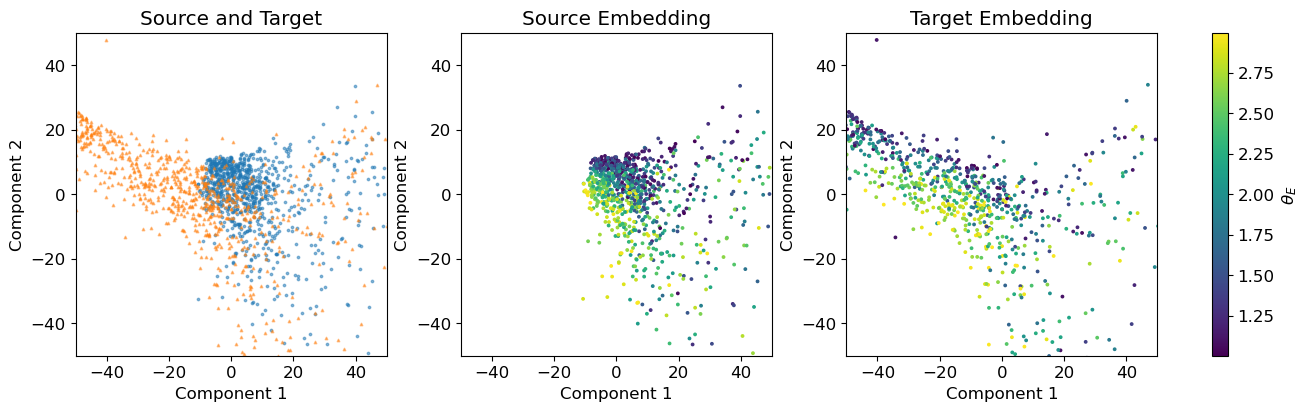


Epoch 20: 37.50s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5306
	Train Regression Loss: : 0.0320
	Train Mve Loss: : -0.0784
	Train R2 Score: : 0.9031
 Validation Statistics:
	Val Source Regression Loss: : 0.0320
	Val Target Regression Loss: : 0.1370
	Val Source R2 Score: : 0.9020
	Val Target R2 Score: : 0.5918
	Val Source Mve Loss: : -0.0726
	Val Target Mve Loss: : 0.1013

Epoch 21: 36.18s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5349
	Train Regression Loss: : 0.0301
	Train Mve Loss: : -0.0832
	Train R2 Score: : 0.9091
 Validation Statistics:
	Val Source Regression Loss: : 0.0297
	Val Target Regression Loss: : 0.1366
	Val Source R2 Score: : 0.9091
	Val Target R2 Score: : 0.5958
	Val Source Mve Loss: : -0.0835
	Val Target Mve Loss: : 0.0530

Epoch 22: 37.74s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5366
	Train Regression Loss: : 0.0281
	Train Mve Loss: : -0.0779
	Train R2 Score: : 0.9148
 

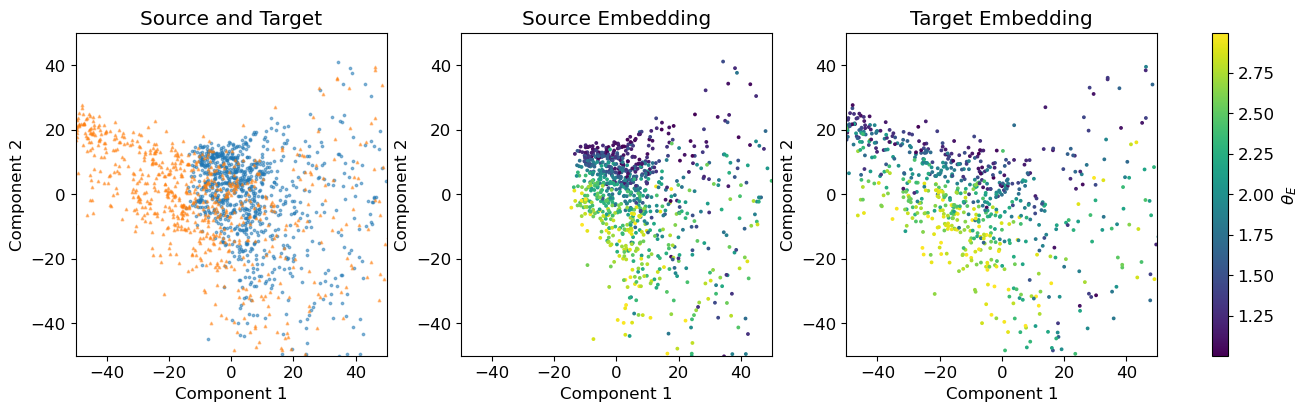


Epoch 40: 36.68s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5293
	Train Regression Loss: : 0.0179
	Train Mve Loss: : -0.1113
	Train R2 Score: : 0.9456
 Validation Statistics:
	Val Source Regression Loss: : 0.0186
	Val Target Regression Loss: : 0.1742
	Val Source R2 Score: : 0.9433
	Val Target R2 Score: : 0.4838
	Val Source Mve Loss: : -0.0917
	Val Target Mve Loss: : 0.9571

Epoch 41: 38.63s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5294
	Train Regression Loss: : 0.0178
	Train Mve Loss: : -0.0966
	Train R2 Score: : 0.9461
 Validation Statistics:
	Val Source Regression Loss: : 0.0183
	Val Target Regression Loss: : 0.1815
	Val Source R2 Score: : 0.9438
	Val Target R2 Score: : 0.4612
	Val Source Mve Loss: : -0.0879
	Val Target Mve Loss: : 1.0044

Epoch 42: 39.95s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5318
	Train Regression Loss: : 0.0175
	Train Mve Loss: : -0.1069
	Train R2 Score: : 0.9471
 

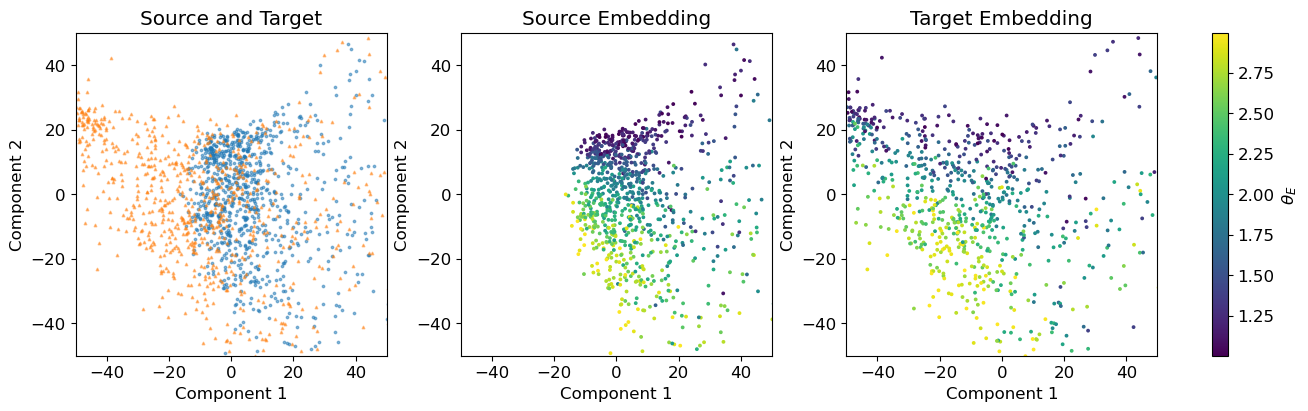


Epoch 60: 37.62s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5279
	Train Regression Loss: : 0.0145
	Train Mve Loss: : -0.1695
	Train R2 Score: : 0.9560
 Validation Statistics:
	Val Source Regression Loss: : 0.0150
	Val Target Regression Loss: : 0.2195
	Val Source R2 Score: : 0.9540
	Val Target R2 Score: : 0.3451
	Val Source Mve Loss: : -0.1418
	Val Target Mve Loss: : 2.6742

Epoch 61: 38.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5249
	Train Regression Loss: : 0.0146
	Train Mve Loss: : -0.1391
	Train R2 Score: : 0.9558
 Validation Statistics:
	Val Source Regression Loss: : 0.0149
	Val Target Regression Loss: : 0.2236
	Val Source R2 Score: : 0.9544
	Val Target R2 Score: : 0.3364
	Val Source Mve Loss: : -0.1275
	Val Target Mve Loss: : 3.0571

Epoch 62: 40.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5269
	Train Regression Loss: : 0.0146
	Train Mve Loss: : -0.1200
	Train R2 Score: : 0.9559
 

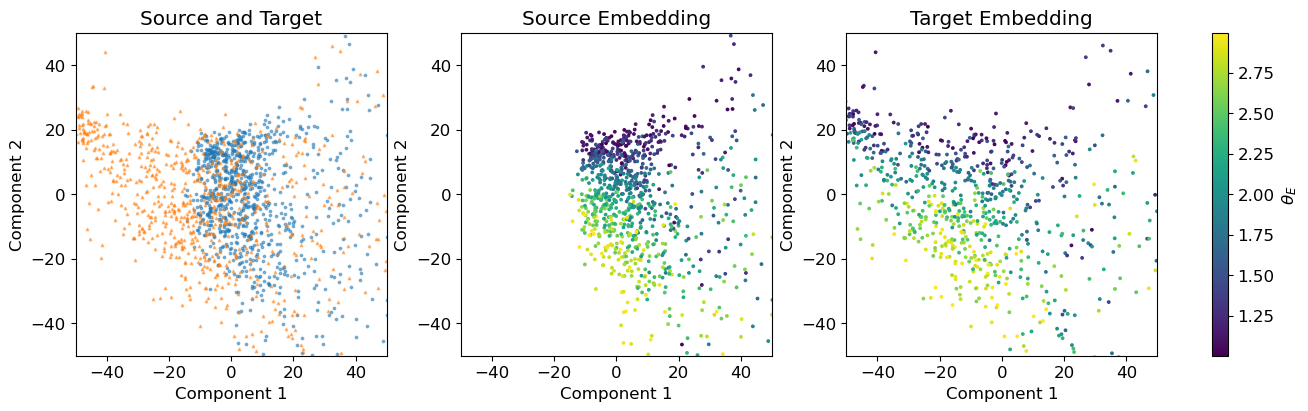


Epoch 80: 39.04s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5206
	Train Regression Loss: : 0.0131
	Train Mve Loss: : -0.1807
	Train R2 Score: : 0.9604
 Validation Statistics:
	Val Source Regression Loss: : 0.0137
	Val Target Regression Loss: : 0.2562
	Val Source R2 Score: : 0.9580
	Val Target R2 Score: : 0.2335
	Val Source Mve Loss: : -0.1608
	Val Target Mve Loss: : 8.4864

Epoch 81: 36.17s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5239
	Train Regression Loss: : 0.0130
	Train Mve Loss: : -0.1542
	Train R2 Score: : 0.9606
 Validation Statistics:
	Val Source Regression Loss: : 0.0137
	Val Target Regression Loss: : 0.2611
	Val Source R2 Score: : 0.9576
	Val Target R2 Score: : 0.2268
	Val Source Mve Loss: : -0.1309
	Val Target Mve Loss: : 11.8266

Epoch 82: 38.45s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5241
	Train Regression Loss: : 0.0129
	Train Mve Loss: : -0.1947
	Train R2 Score: : 0.9607


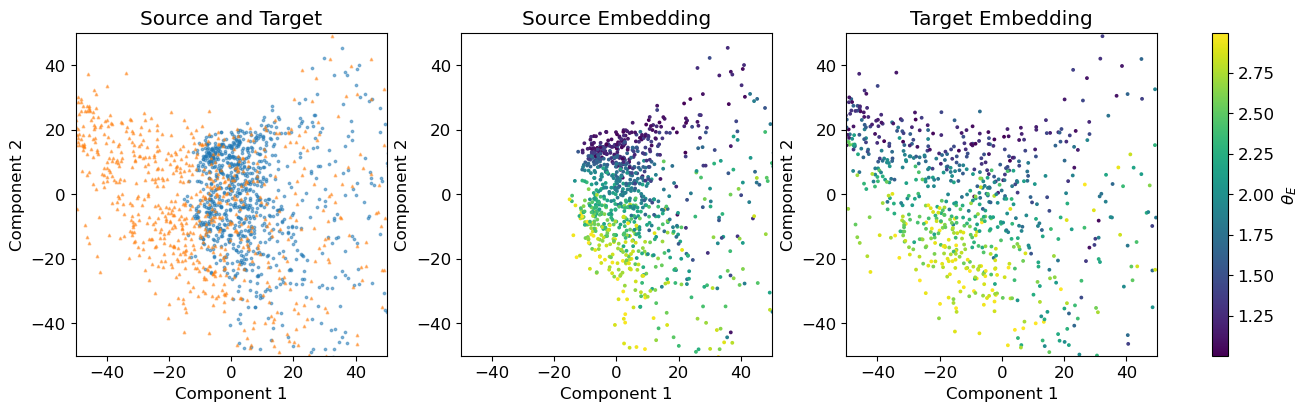


Epoch 100: 38.00s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5275
	Train Regression Loss: : 0.0122
	Train Mve Loss: : -0.2098
	Train R2 Score: : 0.9632
 Validation Statistics:
	Val Source Regression Loss: : 0.0124
	Val Target Regression Loss: : 0.2941
	Val Source R2 Score: : 0.9620
	Val Target R2 Score: : 0.1279
	Val Source Mve Loss: : -0.2068
	Val Target Mve Loss: : 65.5359

Epoch 101: 37.88s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5273
	Train Regression Loss: : 0.0121
	Train Mve Loss: : -0.1782
	Train R2 Score: : 0.9634
 Validation Statistics:
	Val Source Regression Loss: : 0.0122
	Val Target Regression Loss: : 0.2921
	Val Source R2 Score: : 0.9625
	Val Target R2 Score: : 0.1332
	Val Source Mve Loss: : -0.0994
	Val Target Mve Loss: : 76.0611

Epoch 102: 37.93s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5274
	Train Regression Loss: : 0.0120
	Train Mve Loss: : -0.1781
	Train R2 Score: : 0.9

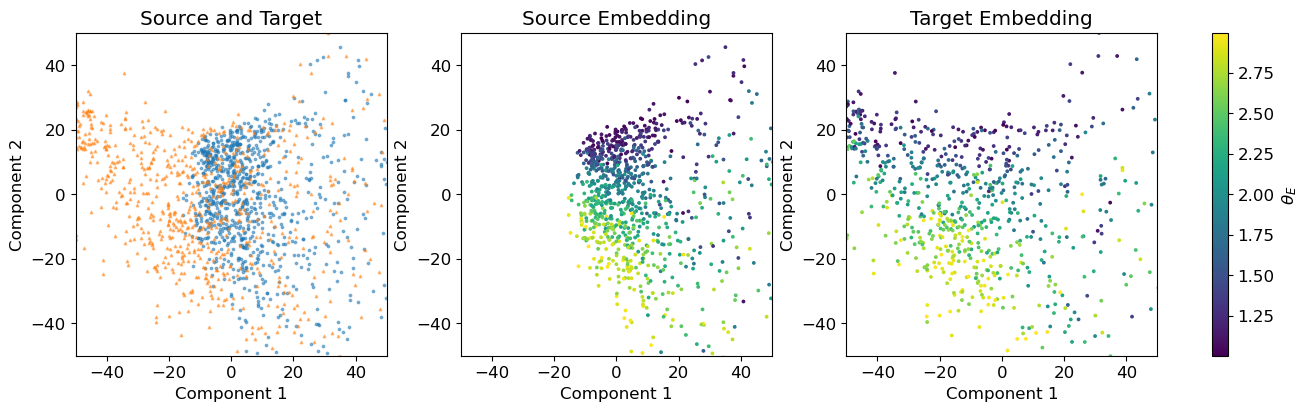


Epoch 120: 39.06s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5262
	Train Regression Loss: : 0.0117
	Train Mve Loss: : -0.2918
	Train R2 Score: : 0.9646
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.3001
	Val Source R2 Score: : 0.9632
	Val Target R2 Score: : 0.1077
	Val Source Mve Loss: : -0.2873
	Val Target Mve Loss: : 196.2380

Epoch 121: 38.91s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5276
	Train Regression Loss: : 0.0117
	Train Mve Loss: : -0.2911
	Train R2 Score: : 0.9647
 Validation Statistics:
	Val Source Regression Loss: : 0.0120
	Val Target Regression Loss: : 0.3024
	Val Source R2 Score: : 0.9633
	Val Target R2 Score: : 0.1002
	Val Source Mve Loss: : -0.2514
	Val Target Mve Loss: : 215.7680

Epoch 122: 37.38s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5280
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.2609
	Train R2 Score: : 0

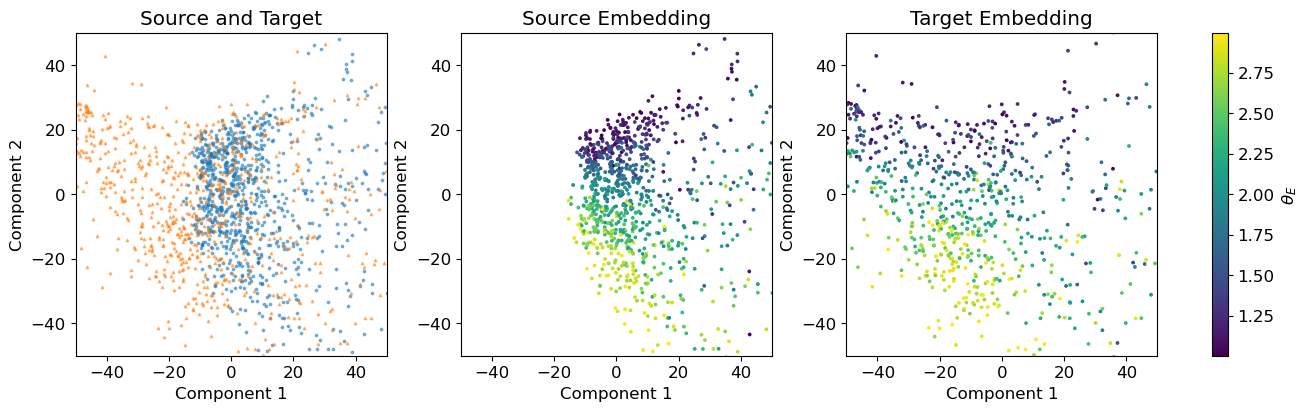


Epoch 140: 36.34s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5259
	Train Regression Loss: : 0.0117
	Train Mve Loss: : -0.3637
	Train R2 Score: : 0.9646
 Validation Statistics:
	Val Source Regression Loss: : 0.0123
	Val Target Regression Loss: : 0.2931
	Val Source R2 Score: : 0.9616
	Val Target R2 Score: : 0.1012
	Val Source Mve Loss: : -0.3699
	Val Target Mve Loss: : 724.2830

Epoch 141: 38.39s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5251
	Train Regression Loss: : 0.0116
	Train Mve Loss: : -0.2865
	Train R2 Score: : 0.9648
 Validation Statistics:
	Val Source Regression Loss: : 0.0120
	Val Target Regression Loss: : 0.2997
	Val Source R2 Score: : 0.9629
	Val Target R2 Score: : 0.0979
	Val Source Mve Loss: : -0.0416
	Val Target Mve Loss: : 818.3283

Epoch 142: 39.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5195
	Train Regression Loss: : 0.0116
	Train Mve Loss: : -0.2368
	Train R2 Score: : 0

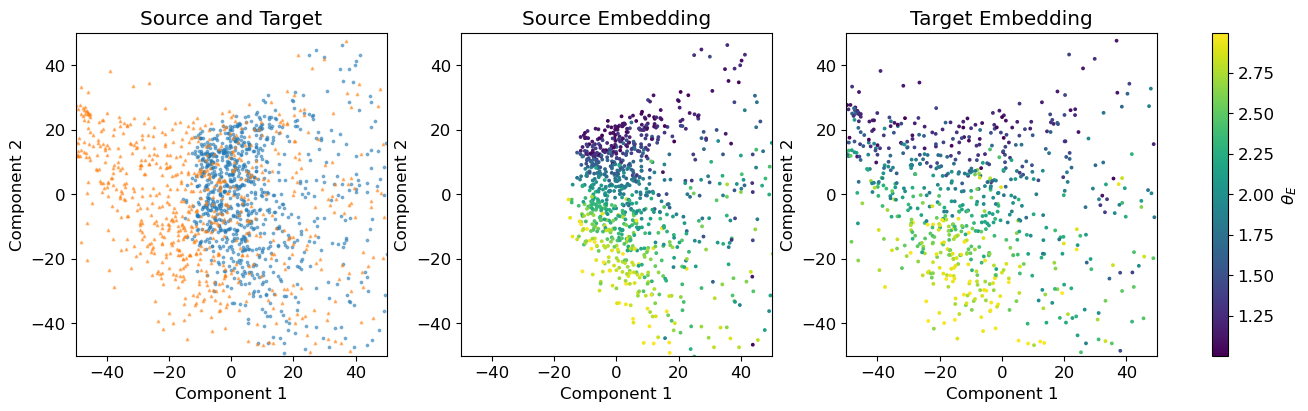


Epoch 160: 37.37s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5236
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.2725
	Train R2 Score: : 0.9653
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.3097
	Val Source R2 Score: : 0.9641
	Val Target R2 Score: : 0.0749
	Val Source Mve Loss: : 0.3112
	Val Target Mve Loss: : 2716.9446

Epoch 161: 36.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5236
	Train Regression Loss: : 0.0114
	Train Mve Loss: : -0.0862
	Train R2 Score: : 0.9654
 Validation Statistics:
	Val Source Regression Loss: : 0.0114
	Val Target Regression Loss: : 0.3112
	Val Source R2 Score: : 0.9653
	Val Target R2 Score: : 0.0771
	Val Source Mve Loss: : 0.2681
	Val Target Mve Loss: : 2816.0322

Epoch 162: 38.51s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5246
	Train Regression Loss: : 0.0113
	Train Mve Loss: : -0.0655
	Train R2 Score: : 0

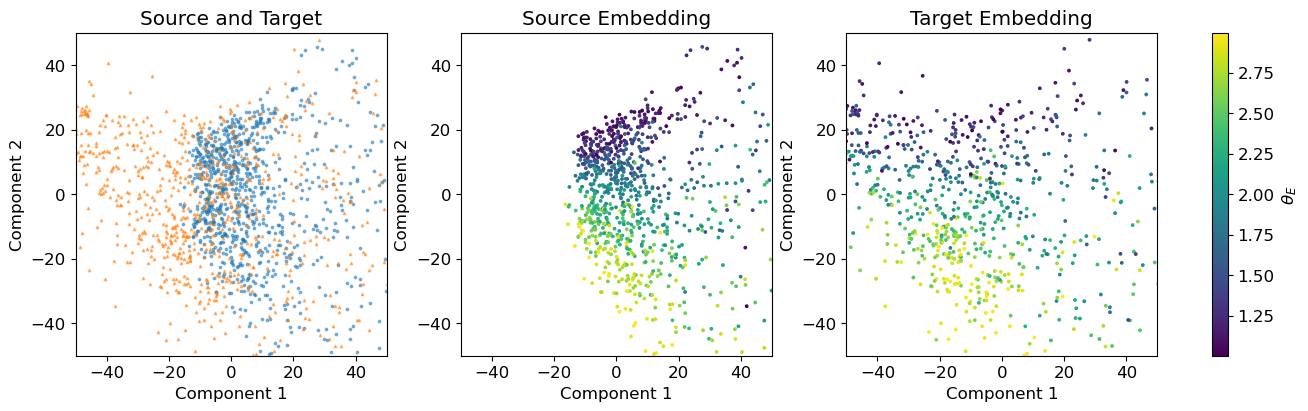


Epoch 180: 35.67s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5248
	Train Regression Loss: : 0.0117
	Train Mve Loss: : -0.4459
	Train R2 Score: : 0.9647
 Validation Statistics:
	Val Source Regression Loss: : 0.0127
	Val Target Regression Loss: : 0.2966
	Val Source R2 Score: : 0.9614
	Val Target R2 Score: : 0.1097
	Val Source Mve Loss: : -0.1520
	Val Target Mve Loss: : 8352.1946

Epoch 181: 38.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5256
	Train Regression Loss: : 0.0118
	Train Mve Loss: : -0.1980
	Train R2 Score: : 0.9644
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.3041
	Val Source R2 Score: : 0.9636
	Val Target R2 Score: : 0.0998
	Val Source Mve Loss: : 1.7944
	Val Target Mve Loss: : 9619.0878

Epoch 182: 39.86s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5245
	Train Regression Loss: : 0.0115
	Train Mve Loss: : 0.0586
	Train R2 Score: : 0

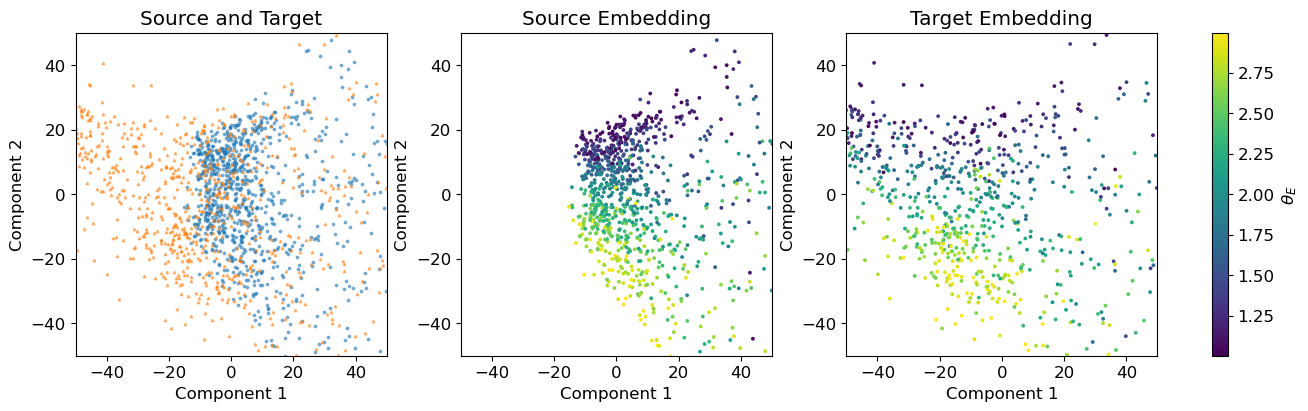


Epoch 200: 36.92s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5217
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.0837
	Train R2 Score: : 0.9650
 Validation Statistics:
	Val Source Regression Loss: : 0.0120
	Val Target Regression Loss: : 0.3177
	Val Source R2 Score: : 0.9635
	Val Target R2 Score: : 0.0551
	Val Source Mve Loss: : 6.0374
	Val Target Mve Loss: : 32011.4830

Epoch 201: 37.15s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5234
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.1226
	Train R2 Score: : 0.9651
 Validation Statistics:
	Val Source Regression Loss: : 0.0118
	Val Target Regression Loss: : 0.3132
	Val Source R2 Score: : 0.9639
	Val Target R2 Score: : 0.0675
	Val Source Mve Loss: : 2.7514
	Val Target Mve Loss: : 33238.3490

Epoch 202: 39.14s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5248
	Train Regression Loss: : 0.0115
	Train Mve Loss: : -0.3403
	Train R2 Score: :

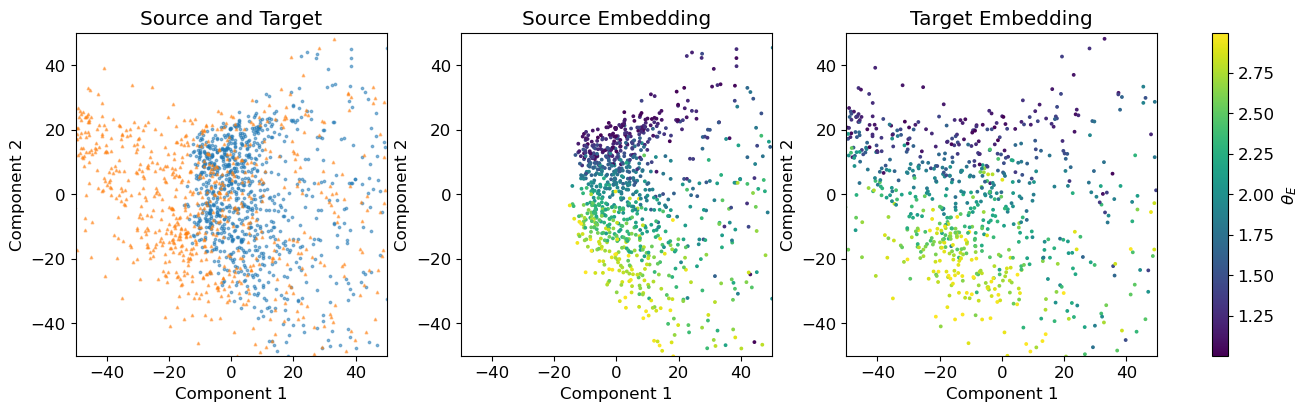


Epoch 220: 38.20s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5230
	Train Regression Loss: : 0.0113
	Train Mve Loss: : -0.4643
	Train R2 Score: : 0.9657
 Validation Statistics:
	Val Source Regression Loss: : 0.0116
	Val Target Regression Loss: : 0.3096
	Val Source R2 Score: : 0.9645
	Val Target R2 Score: : 0.0768
	Val Source Mve Loss: : 1.8464
	Val Target Mve Loss: : 122170.5689

Epoch 221: 38.58s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5251
	Train Regression Loss: : 0.0114
	Train Mve Loss: : -0.2818
	Train R2 Score: : 0.9654
 Validation Statistics:
	Val Source Regression Loss: : 0.0120
	Val Target Regression Loss: : 0.3091
	Val Source R2 Score: : 0.9634
	Val Target R2 Score: : 0.0841
	Val Source Mve Loss: : 9.3204
	Val Target Mve Loss: : 132987.4561

Epoch 222: 35.87s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5239
	Train Regression Loss: : 0.0114
	Train Mve Loss: : -0.3017
	Train R2 Score:

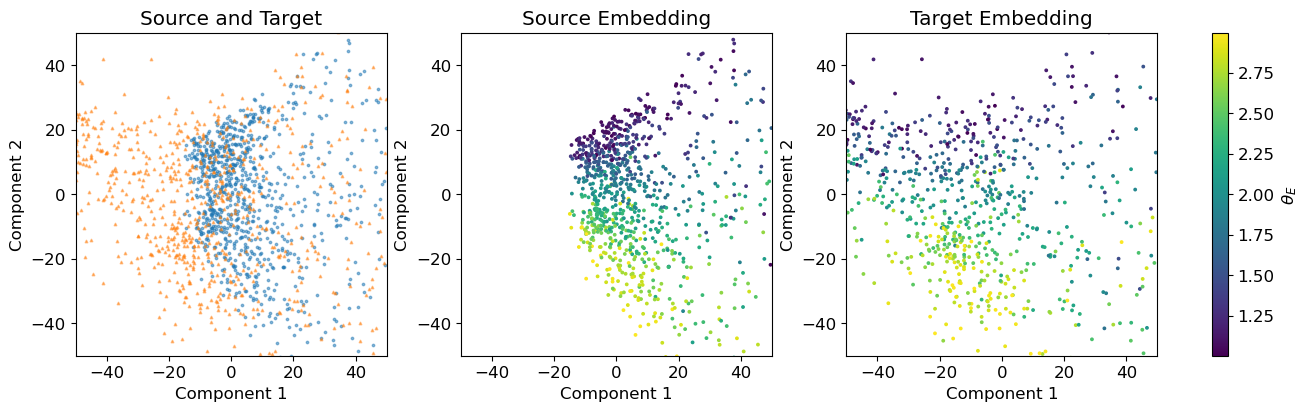


Epoch 240: 37.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5210
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 29.5594
	Train R2 Score: : 0.9661
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.2996
	Val Source R2 Score: : 0.9646
	Val Target R2 Score: : 0.1011
	Val Source Mve Loss: : 85.0282
	Val Target Mve Loss: : 538135.2638

Epoch 241: 37.44s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5201
	Train Regression Loss: : 0.0111
	Train Mve Loss: : 21.2450
	Train R2 Score: : 0.9663
 Validation Statistics:
	Val Source Regression Loss: : 0.0117
	Val Target Regression Loss: : 0.3103
	Val Source R2 Score: : 0.9638
	Val Target R2 Score: : 0.0737
	Val Source Mve Loss: : 129.2512
	Val Target Mve Loss: : 595439.6084

Epoch 242: 36.76s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5222
	Train Regression Loss: : 0.0109
	Train Mve Loss: : 18.6206
	Train R2 Sco

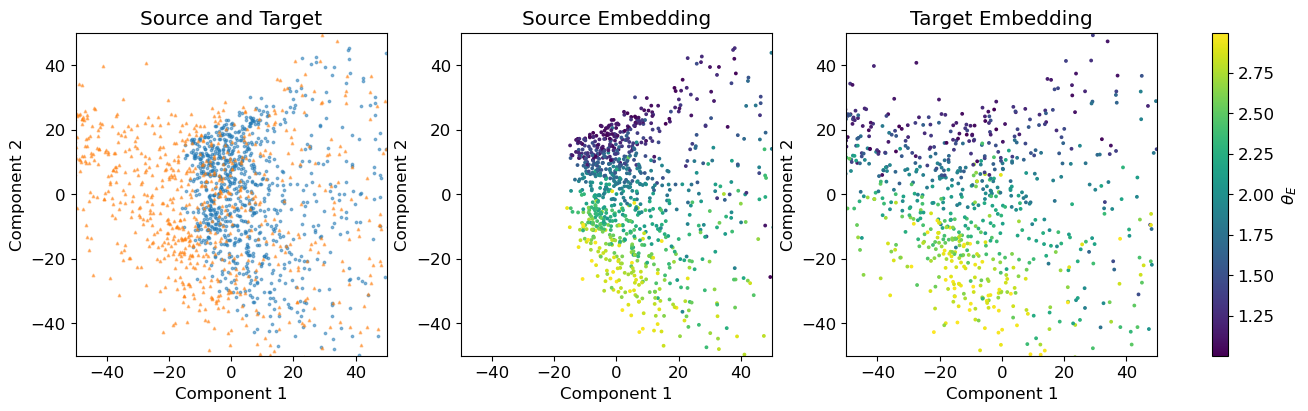


Epoch 260: 35.32s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5192
	Train Regression Loss: : 0.0111
	Train Mve Loss: : 5.7997
	Train R2 Score: : 0.9665
 Validation Statistics:
	Val Source Regression Loss: : 0.0116
	Val Target Regression Loss: : 0.3080
	Val Source R2 Score: : 0.9643
	Val Target R2 Score: : 0.0822
	Val Source Mve Loss: : 42.6238
	Val Target Mve Loss: : 997880.6820

Epoch 261: 37.90s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5190
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 13.2024
	Train R2 Score: : 0.9661
 Validation Statistics:
	Val Source Regression Loss: : 0.0115
	Val Target Regression Loss: : 0.3106
	Val Source R2 Score: : 0.9649
	Val Target R2 Score: : 0.0726
	Val Source Mve Loss: : 117.6116
	Val Target Mve Loss: : 1025954.1416

Epoch 262: 37.54s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5170
	Train Regression Loss: : 0.0111
	Train Mve Loss: : 11.2312
	Train R2 Sco

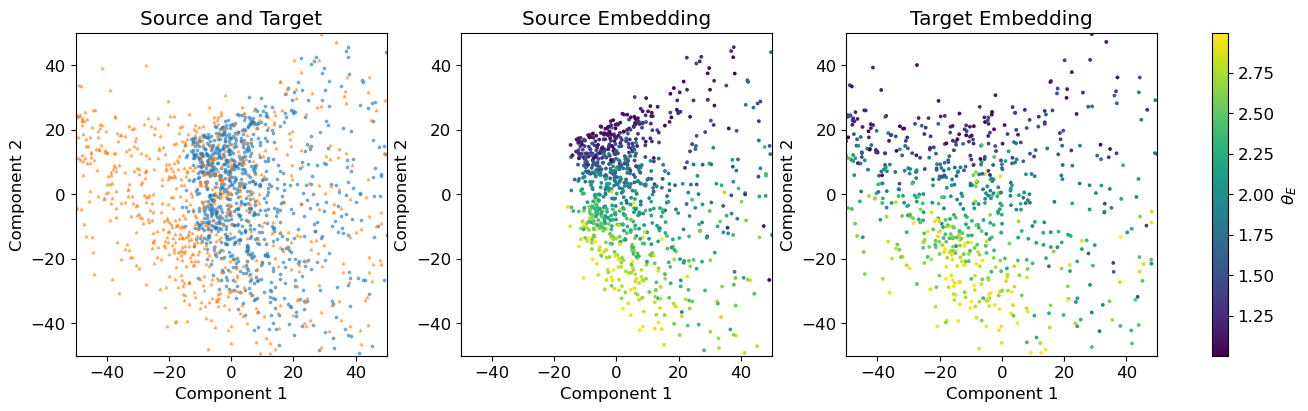


Epoch 280: 37.24s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5200
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 1.1965
	Train R2 Score: : 0.9662
 Validation Statistics:
	Val Source Regression Loss: : 0.0119
	Val Target Regression Loss: : 0.3072
	Val Source R2 Score: : 0.9635
	Val Target R2 Score: : 0.0839
	Val Source Mve Loss: : 32.5536
	Val Target Mve Loss: : 954689.0388

Epoch 281: 38.41s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5221
	Train Regression Loss: : 0.0112
	Train Mve Loss: : 3.3952
	Train R2 Score: : 0.9660
 Validation Statistics:
	Val Source Regression Loss: : 0.0114
	Val Target Regression Loss: : 0.3057
	Val Source R2 Score: : 0.9650
	Val Target R2 Score: : 0.1005
	Val Source Mve Loss: : 86.9687
	Val Target Mve Loss: : 952606.5807

Epoch 282: 36.85s
-------------------------------
 Training Statistics:
	Train Da Loss: : 0.5203
	Train Regression Loss: : 0.0113
	Train Mve Loss: : 2.1618
	Train R2 Score: 

In [9]:
print("Beginning Training...")

stats['lr'] = []
for curr_epoch in range(stats['epoch_no'], stats['epoch_no'] + n_epoch):

        # Generate isomaps every 20 epochs
        if (curr_epoch % 20 == 0):
            print("Generating Isomap...")
            source_iso, target_iso = generate_isomaps(source_data, target_data, model)
            show_isomaps(source_iso, 
                         target_iso, 
                         isomap_source_label_sample, 
                         isomap_target_label_sample, 
                         save_mod_name, 
                         name = stats["epoch_no"], 
                         axlim = 50, save = True)

        # Save best models
        if (len(stats['val_target_r2_score']) > 0):
            
            # Save and overwrite model every best target R2
            if (stats['val_target_r2_score'][-1] > best_target_R2):
                print("Saving Model...", end = ' ')
                save_model(save_mod_name, model, optimizer, stats)
                best_target_R2 = stats['val_target_r2_score'][-1]
                print("Done.")
                
            # Save and overwrite model every best target MVE Loss
            if (stats['val_target_mve_loss'][-1] < best_mve_loss):
                print("Saving Model MVE...", end = ' ')
                mve_name = save_mod_name + "_mve"
                save_model(mve_name, model, optimizer, stats)
                best_mve_loss = stats['val_target_mve_loss'][-1]
                print("Done.")

            if ((curr_epoch > 250) and (stats['val_target_r2_score'][-1] > 0.95) and (stats['val_target_mve_loss'][-1] < -1)):
                print("Saving Model Minima...", end = ' ')
                m_name = save_mod_name + f"_{curr_epoch}"
                save_model(m_name, model, optimizer, stats)
                print("Done.")

        
        start_time = time.time()

        beta = beta_function(curr_epoch)
        da_weight = da_weight_function(curr_epoch)

        # Train, backpropagate
        vals = train_loop_mve(source_train_dataloader, 
                              target_train_dataloader, 
                              model,
                              regressor_loss_fn, 
                              da_loss_fn, 
                              optimizer,
                              da_weight, 
                              beta)

        # Test, validate metrics
        vals_validate = test_loop_mve(source_val_dataloader, 
                                      target_val_dataloader,
                                      model, 
                                      regressor_loss_fn, 
                                      beta)

        scheduler.step()

        # Training Metrics
        stats['train_DA_loss'].append(vals[0])
        stats['train_regression_loss'].append(vals[1])
        stats['train_mve_loss'].append(vals[2])
        stats['train_r2_score'].append(vals[3])

        # Validation Metrics
        stats['val_source_regression_loss'].append(vals_validate[0])
        stats['val_target_regression_loss'].append(vals_validate[1])
        stats['val_source_r2_score'].append(vals_validate[2])
        stats['val_target_r2_score'].append(vals_validate[3])
        stats['val_source_mve_loss'].append(vals_validate[4])
        stats['val_target_mve_loss'].append(vals_validate[5])
        
        # Other Parameters
        stats['da_weight'].append(da_weight)
        stats['beta'].append(beta)
        stats['epoch_no'] += 1
        stats['lr'].append(scheduler.get_last_lr())
        print_epoch_scores(stats, curr_epoch, time.time() - start_time)

In [10]:
# Saves the end result model after running for all stages, as well as the .json of stats

state = {
    'epoch': stats['epoch_no'],
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}
final_mod_name = save_mod_name + "_final"
torch.save(state, final_mod_name)
json.dump(stats, open(final_mod_name+'.json', 'w'))

## Visualize Results

In [34]:
# Loads a model for plotting/viz

viz_mod_name = "models/papermve_v3_aug22_1315_A_mve" # "models/start_code_test_4_final"
model.load_state_dict(torch.load(viz_mod_name)['state_dict'])
stats = json.load(open(viz_mod_name+'.json', 'r'))

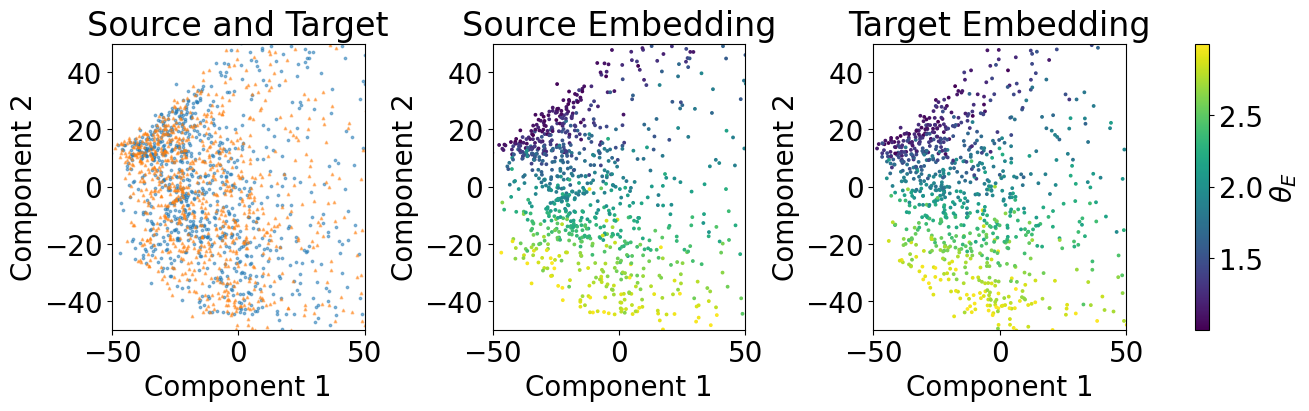

(<Figure size 1300x400 with 4 Axes>,
 array([<Axes: title={'center': 'Source and Target'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Source Embedding'}, xlabel='Component 1', ylabel='Component 2'>,
        <Axes: title={'center': 'Target Embedding'}, xlabel='Component 1', ylabel='Component 2'>],
       dtype=object))

In [35]:
# Visualize isomaps 
trained_source_iso, trained_target_iso = generate_isomaps(source_data, target_data, model)
show_isomaps(trained_source_iso, trained_target_iso, isomap_source_label_sample, isomap_target_label_sample, viz_mod_name, axlim = 50)

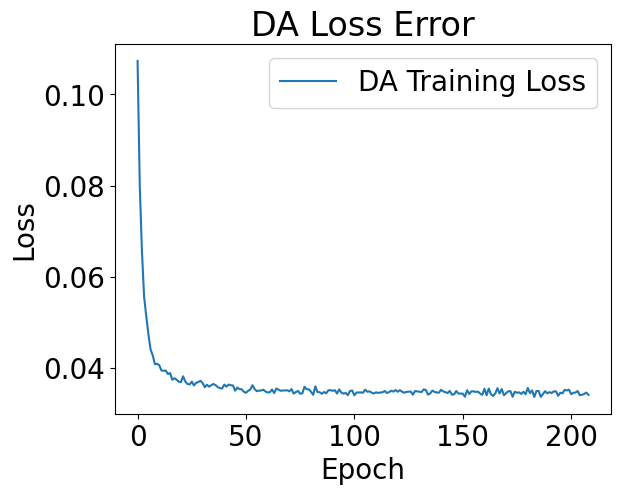

In [36]:
# DA Loss
fmt = lambda k: " ".join([i.capitalize() for i in k.split('_')])
eps = np.arange(stats["epoch_no"])
plt.title("DA Loss Error")
plt.plot(eps, stats['train_DA_loss'], label = "DA Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

(0.0, 0.05)

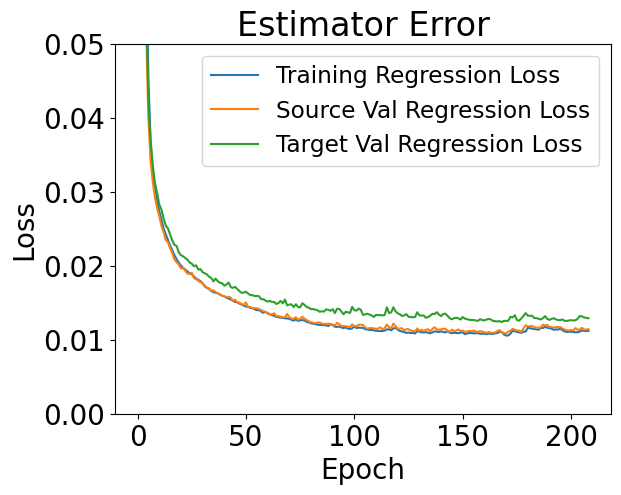

In [37]:
# Estimator / Regression
plt.title("Estimator Error")
plt.plot(eps, stats['train_regression_loss'], label = "Training Regression Loss")
plt.plot(eps, stats['val_source_regression_loss'], label = "Source Val Regression Loss")
plt.plot(eps, stats['val_target_regression_loss'], label = "Target Val Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(0, 0.05)

(-2.0, 10.0)

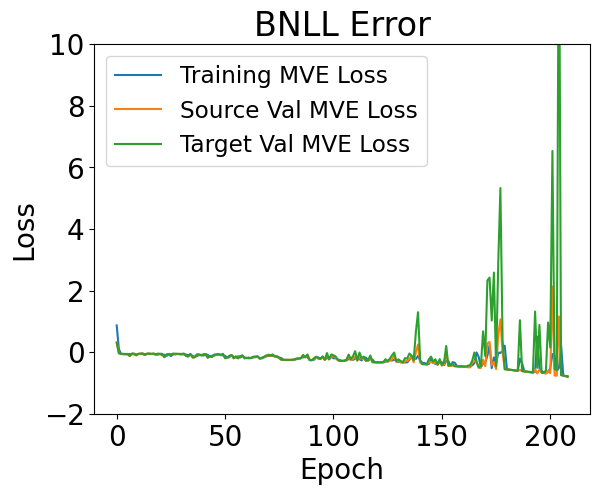

In [38]:
# BNLL for MVE
plt.title("BNLL Error")
plt.plot(eps, stats['train_mve_loss'], label = "Training MVE Loss")
plt.plot(eps, stats['val_source_mve_loss'], label = "Source Val MVE Loss")
plt.plot(eps, stats['val_target_mve_loss'], label = "Target Val MVE Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(fontsize = 'small')
plt.ylim(-2, 10)

(0.5, 1.0)

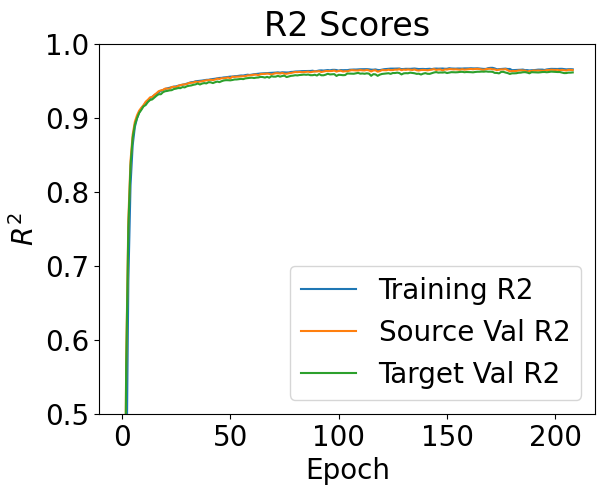

In [39]:
# R2 Scores
plt.title("R2 Scores")
plt.plot(eps, stats['train_r2_score'], label = "Training R2")
plt.plot(eps, stats['val_source_r2_score'], label = "Source Val R2")
plt.plot(eps, stats['val_target_r2_score'], label = "Target Val R2")
plt.xlabel("Epoch")
plt.ylabel("$R^2$")
plt.legend()
plt.ylim(0.5, 1)

In [40]:
# Test Source
var_preds_source = np.array([])
preds_source = np.array([])
true_source = np.array([])
lbnll_source = np.array([])
score_list = np.array([])

with torch.no_grad():
    for X, y in source_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_source = np.append(preds_source, pred[:, 0].cpu())
        var_preds_source = np.append(var_preds_source, pred[:, 1].cpu())
        true_source = np.append(true_source, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_source = np.append(lbnll_source, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))

score = np.mean(score_list)
print(f'Source R2 Score is {score:.4f}')

Source R2 Score is 0.9664


Text(0.5, 1.0, 'MMD | Source | R2: 0.966')

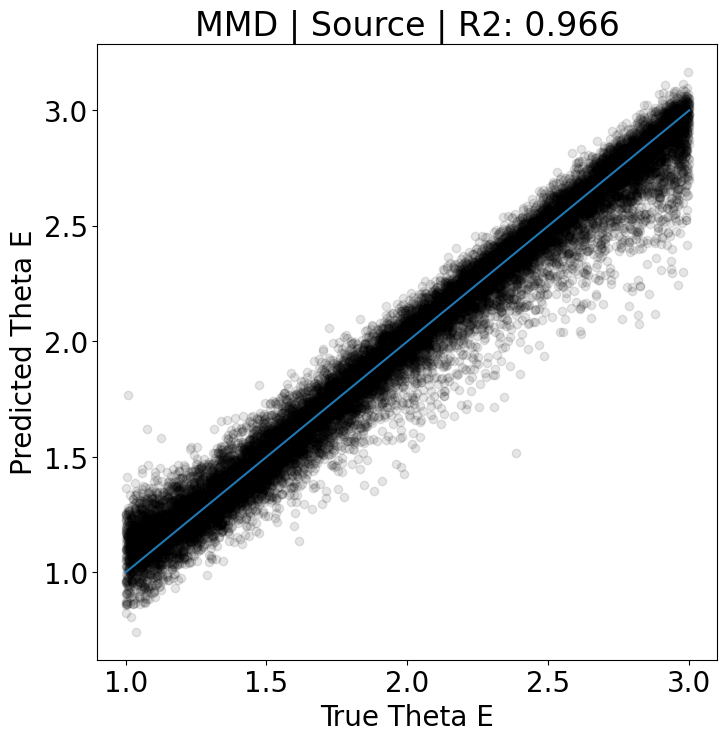

In [41]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, preds_source,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Source | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Source | BNLL: -0.323')

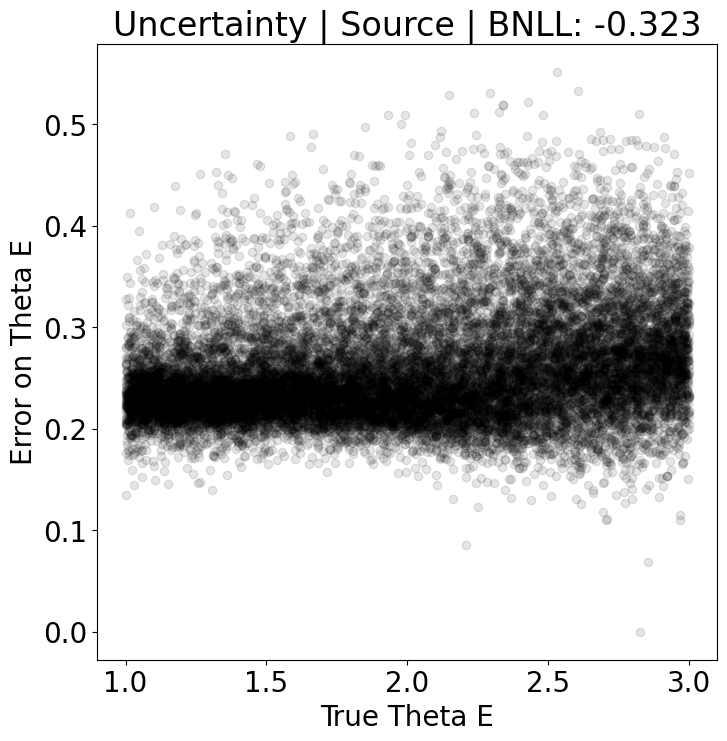

In [42]:
plt.figure(figsize=(8,8))
plt.scatter(true_source, np.sqrt(var_preds_source),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Source | BNLL: {0:.3f}'.format(np.mean(lbnll_source)))

In [43]:
# Test target
preds_target = np.array([])
var_preds_target = np.array([])
true_target = np.array([])
score_list = np.array([])
lbnll_target = np.array([])


with torch.no_grad():
    for X, y in target_test_dataloader:
        X = X.float()
        pred, _ = model(X.cuda())
        preds_target = np.append(preds_target, pred[:, 0].cpu())
        var_preds_target = np.append(var_preds_target, pred[:, 1].cpu())
        true_target = np.append(true_target, y.cpu())
        score = r2_score(y.cpu(), pred[:, 0].cpu())
        score_list = np.append(score_list, score)
        lbnll_target = np.append(lbnll_target, loss_bnll(pred[:, 0].cpu(), pred[:, 1].cpu(), y, beta = 0.5))


score = np.mean(score_list)
print(f'Target R2 Score is {score:.4f}')

Target R2 Score is 0.9598


Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

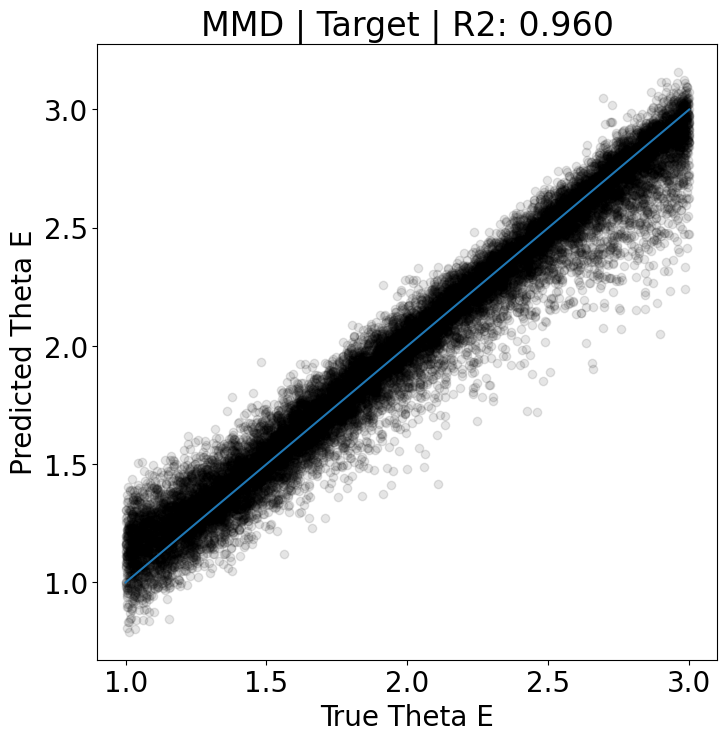

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, preds_target,  color='black', alpha = 0.1)
line = np.linspace(1, 3, 100)
plt.plot(line, line)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'MMD | Target | R2: 0.960')

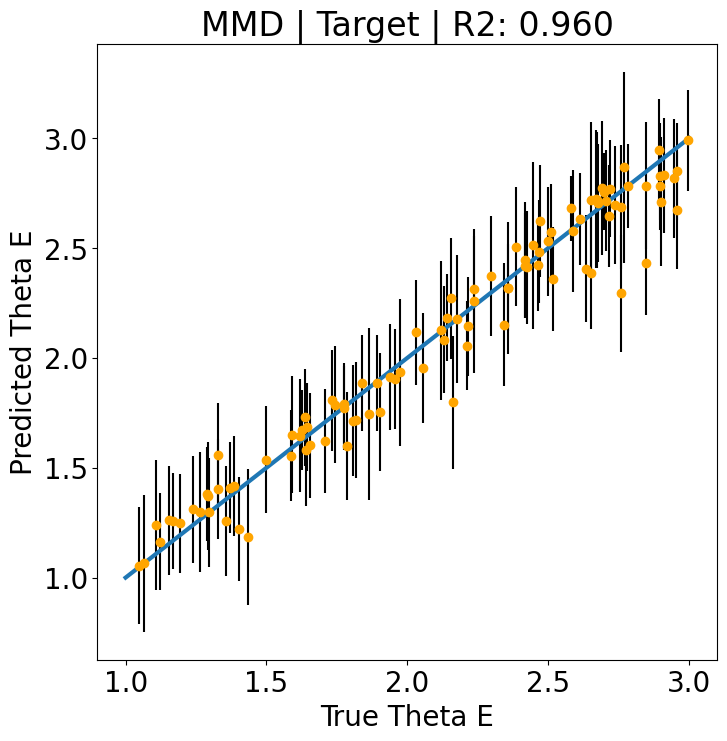

In [45]:
plt.figure(figsize=(8,8))
idx = np.random.choice(np.arange(len(true_target)), 100)
plt.errorbar(true_target[idx], preds_target[idx], yerr = np.sqrt(var_preds_target[idx]), fmt = 'o', color='orange', ecolor = 'k', alpha = 1)
line = np.linspace(1, 3, 100)
plt.plot(line, line, lw = 3)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Predicted Theta E');
plt.rc('font', size=20)
plt.title('MMD | Target | R2: {0:.3f}'.format(np.mean(score_list)))

Text(0.5, 1.0, 'Uncertainty | Target | BNLL: -0.316')

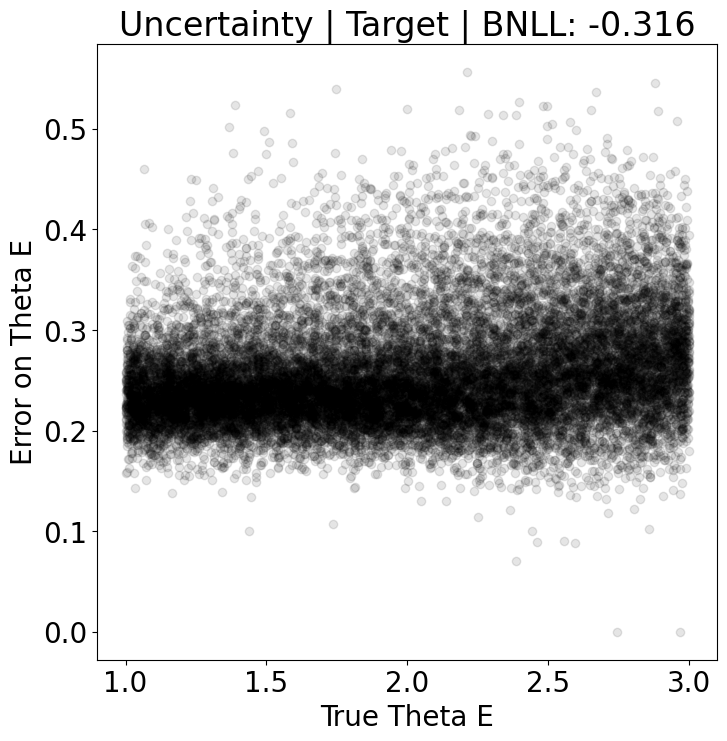

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(true_target, np.sqrt(var_preds_target),  color='black', alpha = 0.1)
plt.rc('font', size=12)
plt.xlabel('True Theta E')
plt.ylabel('Error on Theta E');
plt.rc('font', size=20)
plt.title('Uncertainty | Target | BNLL: {0:.3f}'.format(np.mean(lbnll_target)))

In [47]:
def sample_variance(obs, true):
    return np.std(obs - true) ** 2

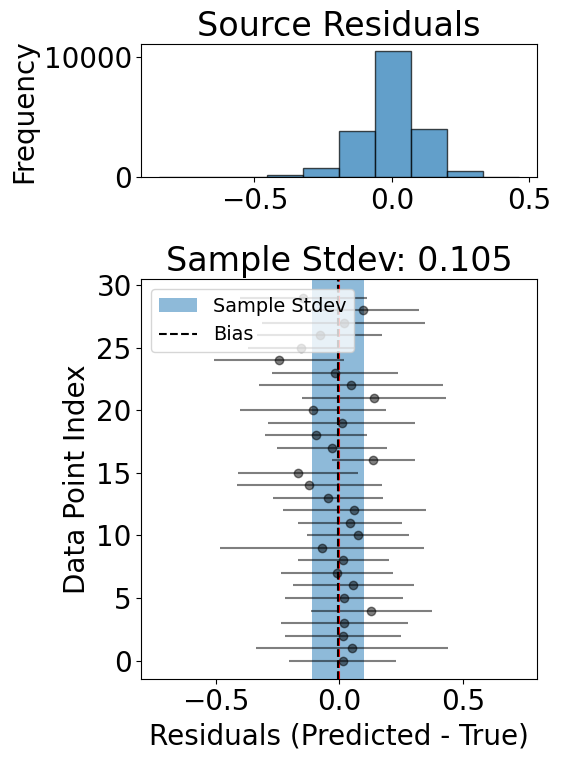

In [48]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_source[rand_idx] - true_source[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_source[rand_idx])
sv = np.sqrt(sample_variance(preds_source, true_source))
mn = np.mean(resid_all)

# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=10, edgecolor='black', alpha=0.7)
ax_hist.set_title('Source Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 'x-small')

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()

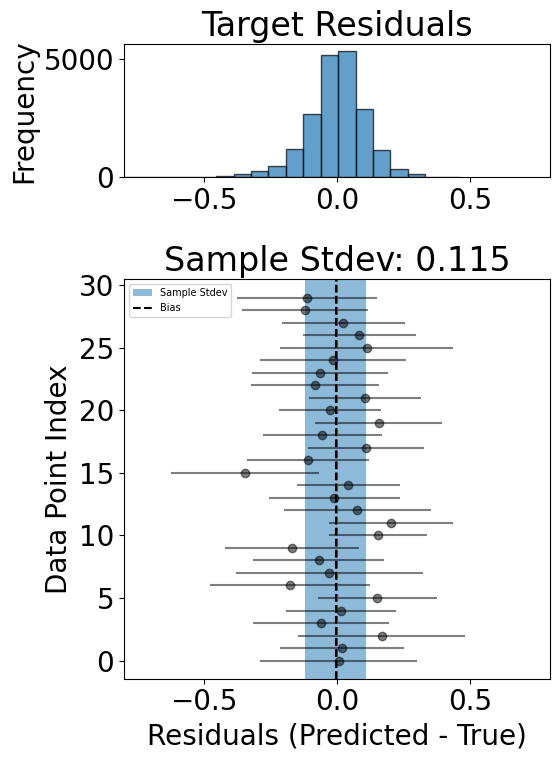

In [49]:
n_points = 30
rand_idx = np.random.choice(np.arange(len(preds_source)), n_points)
residuals = preds_target[rand_idx] - true_target[rand_idx]
resid_all = preds_target - true_target
errors = np.sqrt(var_preds_target[rand_idx])
sv = np.sqrt(sample_variance(preds_target, true_target))
mn = np.mean(resid_all)
# Create the figure and axes
fig, (ax_hist, ax_resid) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]}, figsize=(6, 8))



# Plot the histogram
ax_hist.hist(resid_all, bins=20, edgecolor='black', alpha=0.7)
ax_hist.set_title('Target Residuals')
ax_hist.set_ylabel('Frequency')

# Plot the residuals with error bars in the x-direction
ax_resid.errorbar(x=residuals, y=np.arange(n_points), xerr=errors, fmt='o', alpha=0.5, ecolor = 'k', color = 'k')
ax_resid.axvline(x=0, color='red', linestyle='--')
ax_resid.set_xlabel('Residuals (Predicted - True)')
ax_resid.set_ylabel('Data Point Index')
ax_resid.set_title('Sample Stdev: {0:.3f}'.format(sv))
ax_resid.axvspan(mn-sv, mn+sv, alpha = 0.5, label = "Sample Stdev")
ax_resid.axvline(mn, color = 'k', ls = '--', label = "Bias")
ax_resid.legend(loc = 'upper left', fontsize = 7)
ax_resid.sharex(ax_hist)

plt.xlim(-0.8, 0.8)

plt.tight_layout()
plt.show()